In [2]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# CSVファイルから過去レートを読み込む
df = pd.read_csv("../data/usd_jpy_api.csv")
df.head()

,time,close,open,high,low,volume
0,2016/08/19 06:00:00,100.256,99.919,100.471,99.887,30965
1,2016/08/22 06:00:00,100.335,100.832,100.944,100.221,32920
2,2016/08/23 06:00:00,100.253,100.339,100.405,99.950,26069
3,2016/08/24 06:00:00,100.460,100.270,100.619,100.104,22340
4,2016/08/25 06:00:00,100.546,100.464,100.627,100.314,17224


In [4]:
# データの最後尾を表示
df.tail()

,time,close,open,high,low,volume
495,2018/07/17 06:00:00,112.908,112.320,112.933,112.231,19645
496,2018/07/18 06:00:00,112.866,112.914,113.144,112.723,17432
497,2018/07/19 06:00:00,112.501,112.887,113.187,112.072,26697
498,2018/07/20 06:00:00,111.474,112.504,112.631,111.401,33445
499,2018/07/23 06:00:00,111.164,111.420,111.523,110.760,16040


In [5]:
# 終値を1日分移動させる
df_shift = df.copy()
df_shift.close = df_shift.close.shift(-1)
 
# 改めてデータを確認
df_shift.tail()

,time,close,open,high,low,volume
495,2018/07/17 06:00:00,112.866,112.320,112.933,112.231,19645
496,2018/07/18 06:00:00,112.501,112.914,113.144,112.723,17432
497,2018/07/19 06:00:00,111.474,112.887,113.187,112.072,26697
498,2018/07/20 06:00:00,111.164,112.504,112.631,111.401,33445
499,2018/07/23 06:00:00,NaN,111.420,111.523,110.760,16040


In [6]:
# 最後の行を除外
df_shift = df_shift[:-1]
 
# 念のためデータをdf_2として新しいデータフレームへコピ−
df_2 = df_shift.copy()
 
# time（時間）を削除
del df_2['time']
 
# データセットのサイズを確認
print(df_2.shape[0])
print(df_2.shape[1])

499
5


In [7]:
# データセットの行数と列数を格納
n = df_2.shape[0]
p = df_2.shape[1]
 
# 訓練データとテストデータへ切り分け
train_start = 0
train_end = int(np.floor(0.8*n))
test_start = train_end + 1
test_end = n
data_train = df_2.loc[np.arange(train_start, train_end), :]
data_test = df_2.loc[np.arange(test_start, test_end), :]
 
# テストデータの最後2行を表示
data_test[97:99]

,close,open,high,low,volume
497,111.474,112.887,113.187,112.072,26697
498,111.164,112.504,112.631,111.401,33445


In [8]:
# データの正規化
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data_train)
data_train_norm = scaler.transform(data_train)
data_test_norm = scaler.transform(data_test)

In [9]:
# 特徴量とターゲットへ切り分け
X_train = data_train_norm[:, 1:]
y_train = data_train_norm[:, 0]
X_test = data_test_norm[:, 1:]
y_test = data_test_norm[:, 0]

In [10]:
# 正規化から通常の値へ戻す
y_test = y_test.reshape(99, 1)
test_inv = np.concatenate((y_test, X_test), axis=1)
test_inv = scaler.inverse_transform(test_inv)

In [11]:
# 正規化の前のテストデータ
print(data_test.values[0])
 
# 正規化後のテストデータ
print(y_test[0], X_test[0])
 
# 正規化から戻したデータ
print(test_inv[0])

[  106.099   106.232   106.47    105.863 29786.   ]
[-0.34859881] [-0.31148435 -0.3361064  -0.32056165 -0.79531038]
[  106.099   106.232   106.47    105.863 29786.   ]


In [12]:
# 訓練データの特徴量の数を取得
n_stocks = X_train.shape[1]
 
# ニューロンの数を設定
n_neurons_1 = 256
n_neurons_2 = 128
 
# セッションの開始
net = tf.compat.v1.InteractiveSession()
 
# プレースホルダーの作成
X = tf.placeholder(dtype=tf.float32, shape=[None, n_stocks])
Y = tf.placeholder(dtype=tf.float32, shape=[None])
 
# 初期化
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

In [13]:
# Hidden weights
W_hidden_1 = tf.Variable(weight_initializer([n_stocks, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))

In [14]:
# 出力の重み
W_out = tf.Variable(weight_initializer([n_neurons_2, 1]))
bias_out = tf.Variable(bias_initializer([1]))

In [15]:
# 隠れ層の設定（ReLU＝活性化関数）
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
 
# 出力層の設定
out = tf.transpose(tf.add(tf.matmul(hidden_2, W_out), bias_out))

In [16]:
# コスト関数
mse = tf.reduce_mean(tf.squared_difference(out, Y))
 
# 最適化関数
opt = tf.train.AdamOptimizer().minimize(mse)
 
# 初期化
net.run(tf.global_variables_initializer())

In [17]:
# ニューラルネットワークの設定
batch_size = 128
mse_train = []
mse_test = []
 
# 訓練開始！500回の反復処理
epochs = 500
for e in range(epochs):
    net.run(opt, feed_dict={X: X_train, Y: y_train})

In [18]:
# テストデータで予測
pred_test = net.run(out, feed_dict={X: X_test})
 
# 予測データの最初の2つを表示
pred_test[0][0:2]

array([-0.33275884, -0.36702645], dtype=float32)

In [19]:
# 予測値をテストデータに戻そう（値も正規化からインバース）
pred_test = np.concatenate((pred_test.T, X_test), axis=1)
pred_inv = scaler.inverse_transform(pred_test)

In [20]:
# 元データの最後尾
df_shift.tail(1)

,time,close,open,high,low,volume
498,2018/07/20 06:00:00,111.164,112.504,112.631,111.401,33445


In [21]:
# テストデータの最後のデータ（正規化前）
print(data_test.values[98])
 
# テストデータの最後のデータ（正規化を戻した後）
print(test_inv[98])
 
# モデルが予測したデータ
print(pred_inv[98])

[  111.164   112.504   112.631   111.401 33445.   ]
[  111.164   112.504   112.631   111.401 33445.   ]
[  111.96763548   112.504        112.631        111.401
 33445.        ]


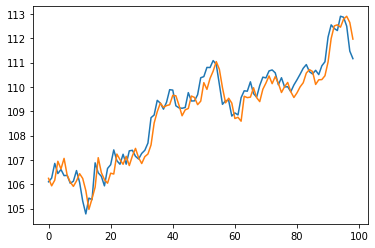

In [22]:
# 予測と実際のテストの終値のチャートをプロットしてみよう
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(test_inv[:,0])
line2, = ax1.plot(pred_inv[:,0])
plt.show()

In [23]:
# MAEの計算
mae_test = mean_absolute_error(test_inv, pred_inv)
print(mae_test)

0.0789601210222326
